##Importing necessary libraries

In [1]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import numpy as np
import pandas as pd
import cv2
import keras
import matplotlib.pyplot as plt
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "keshavmalanib21cs038"
os.environ['KAGGLE_KEY']= "5288201eb4ec1af8506e61aee9641f85"


##Downloading the data 

In [4]:
!kaggle datasets download tawsifurrahman/covid19-radiography-database

covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
replace COVID-19_Radiography_Dataset/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##Reading the data

In [4]:
l=['COVID','Lung_Opacity','Normal','Viral Pneumonia']

In [5]:
img_path=[]
mask_path=[]
label=[]

In [6]:
for i in l:
  k=os.listdir("COVID-19_Radiography_Dataset/"+ i + "/images")
  m=os.listdir("COVID-19_Radiography_Dataset/"+ i + "/masks")
  for j in range(len(k)):
    # print(j)
    img_path.append("COVID-19_Radiography_Dataset/"+ i + "/images/"+k[j])
    mask_path.append("COVID-19_Radiography_Dataset/"+ i + "/masks/"+m[j])
    label.append(i)

In [7]:
df=pd.DataFrame(img_path,columns = ['image_file'])
df['mask_file']=mask_path
df['label']=label
df

,image_file,mask_file,label
0,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID-19_Radiography_Dataset/COVID/masks/COVID...,COVID
1,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID-19_Radiography_Dataset/COVID/masks/COVID...,COVID
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID-19_Radiography_Dataset/COVID/masks/COVID...,COVID
3,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID-19_Radiography_Dataset/COVID/masks/COVID...,COVID
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID-19_Radiography_Dataset/COVID/masks/COVID...,COVID
...,...,...,...
21160,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,COVID-19_Radiography_Dataset/Viral Pneumonia/m...,Viral Pneumonia
21161,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,COVID-19_Radiography_Dataset/Viral Pneumonia/m...,Viral Pneumonia
21162,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,COVID-19_Radiography_Dataset/Viral Pneumonia/m...,Viral Pneumonia
21163,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,COVID-19_Radiography_Dataset/Viral Pneumonia/m...,Viral Pneumonia


#Preprocessing and loading the data

In [8]:
x=[]
y=[]
for i in range(len(df)):
    image = cv2.imread(df['image_file'][i])
    image = cv2.resize(image, (80, 80))
    mask=cv2.imread(df['mask_file'][i])
    mask=cv2.resize(mask, (80, 80))
    # mask=cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY) 
    masked=cv2.bitwise_and(image,mask)
    masked=masked/255.0
    # masked=cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)/255.0
    label = 0
    # label2= 0
    if df['label'][i] == "Normal":
        label = 0
        # label2=0
    elif df['label'][i] == "COVID":
        label = 1
        # label2= 1
    elif df['label'][i] == "Lung_Opacity":
        label = 0
        # label2=0
    else:
        label = 0
        # labwl2= 0
    x.append(masked)
    y.append(label)
    # y2.append(label2)

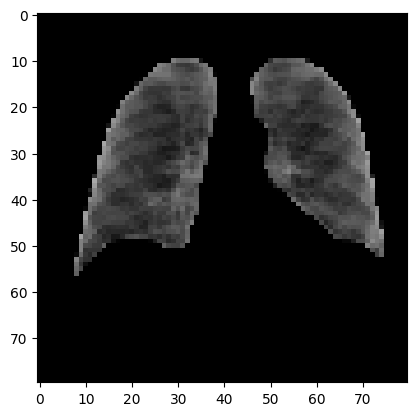

In [11]:
plt.imshow(x[0])

In [9]:
x = np.array(x)
y = np.array(y)
# y2 = np.array(y2)
 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(15238, 80, 80, 3) (4233, 80, 80, 3) (1694, 80, 80, 3) (15238,) (4233,) (1694,)


In [10]:
del x
del y

#Creating the model

In [11]:
def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = train_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units = 256, activation = 'relu'))
    
    cnn_model.add(layers.Dropout(0.2))
    cnn_model.add(layers.Dense(units = 64, activation = 'relu'))

    cnn_model.add(layers.Dense(units = 32,activation='relu'))
    cnn_model.add(layers.Dense(units = 2))
    cnn_model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ['accuracy'])

    cnn_model.summary()
    return cnn_model

In [12]:
input_shape = (80, 80,3)
n_classes= 2

conv_model2 = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 39, 39, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 18, 32)        0

#Running the model

In [14]:
plot_loss_2 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

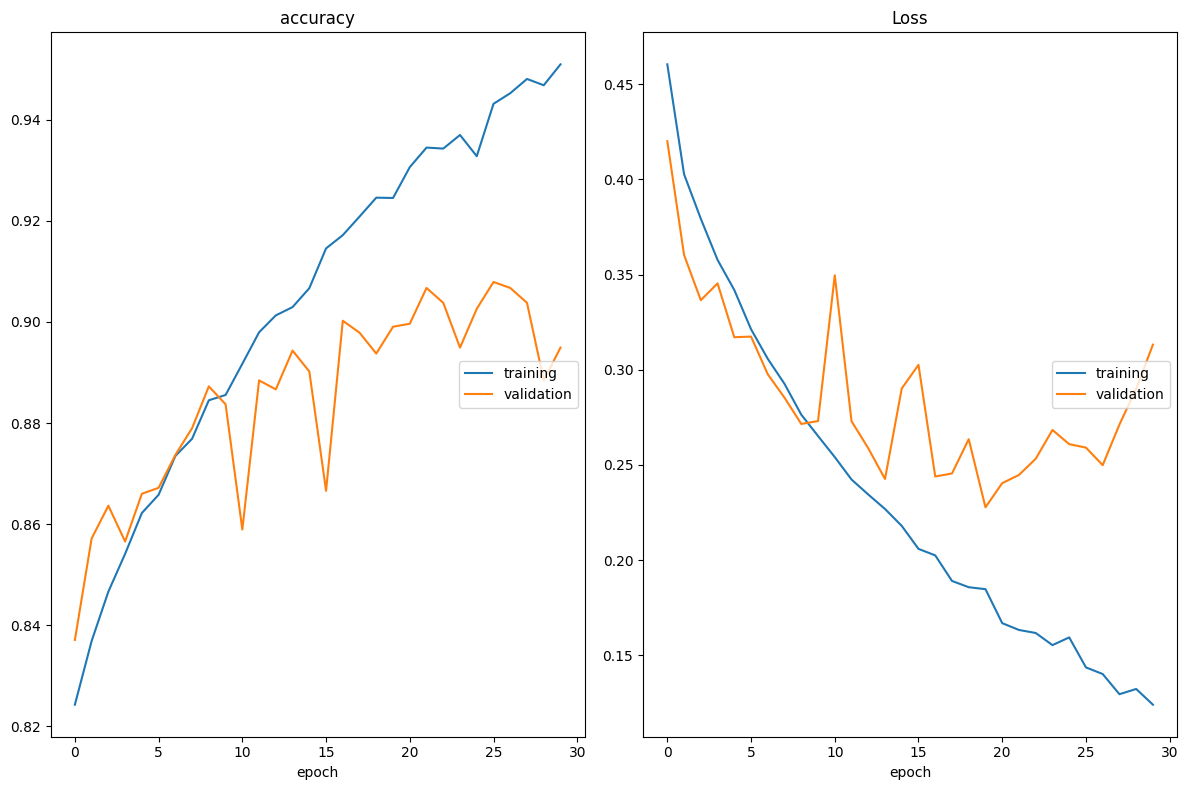

accuracy
	training         	 (min:    0.824, max:    0.951, cur:    0.951)
	validation       	 (min:    0.837, max:    0.908, cur:    0.895)
Loss
	training         	 (min:    0.124, max:    0.460, cur:    0.124)
	validation       	 (min:    0.228, max:    0.420, cur:    0.313)
239/239 [==============================] - 3s 14ms/step - loss: 0.1241 - accuracy: 0.9510 - val_loss: 0.3132 - val_accuracy: 0.8949
CPU times: user 1min 47s, sys: 10.5 s, total: 1min 57s
Wall time: 1min 59s


In [15]:
%%time

plot_loss_2 = PlotLossesCallback()

conv_history = conv_model2.fit(x_train, y_train, 
                        epochs = 50, batch_size = 64,  
                        validation_data = (x_val, y_val), 
                        callbacks = [tl_checkpoint_1, early_stop, plot_loss_2],
                       verbose=1)

#Evaluating the model

In [16]:
yp_train = conv_model2.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = conv_model2.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = conv_model2.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

133/133 [==============================] - 0s 3ms/step


In [17]:
def confusion_matrix_train_test_val(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")

    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")


In [18]:
confusion_matrix_train_test_val("CNN", y_train, yp_train, y_val, yp_val, y_test, yp_test)


-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     12599
           1       0.95      0.80      0.87      2639

    accuracy                           0.96     15238
   macro avg       0.95      0.90      0.92     15238
weighted avg       0.96      0.96      0.96     15238

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1418
           1       0.74      0.58      0.65       276

    accuracy                           0.90      1694
   macro avg       0.83      0.77      0.80      1694
weighted avg       0.89      0.90      0.89      1694

--------------------------------------------------------------------------

Classification Report for Test Data

            